## Imports

In [1]:
from langgraph.graph import StateGraph, START, END

from langchain_groq.chat_models import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

from typing import TypedDict, Annotated, Literal
import operator # python function for operators
from dotenv import load_dotenv
load_dotenv()

True

## LLM based iterative workflow

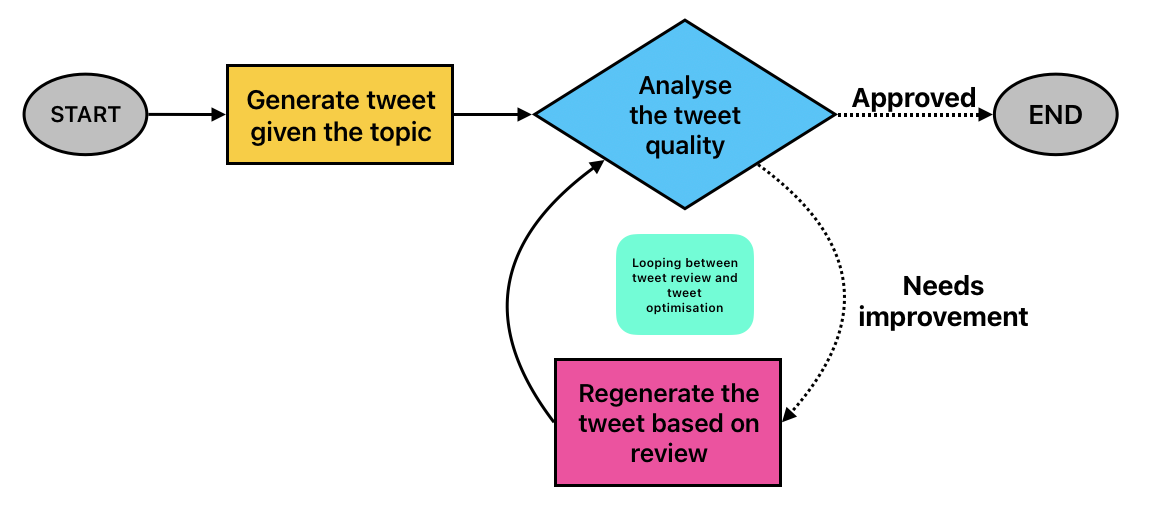

In [2]:
class EvaluationSchema(BaseModel):
    evaluation: Literal["approved", "needs_revision"] = Field(description="Final evaluation of the tweet")
    feedback: str = Field(description="Feedback for the tweet")

class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_revision"]
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.concat]
    feedback_history: Annotated[list[str], operator.concat]

GeneratorLLM = ChatGroq(model="llama-3.1-8b-instant")
EvaluatorLLM = ChatGroq(model="llama-3.1-8b-instant").with_structured_output(EvaluationSchema)
OptimizerLLM = ChatGroq(model="llama-3.1-8b-instant")

In [50]:
def gen_tweet(state: TweetState):
    # prompt template
    messages = [
        SystemMessage(content="You are a social media expert who crafts engaging tweets on various topics."),
        HumanMessage(
            content=f"""
            Create a tweet about the following topic: {state['topic']}
            Rules:
            - The tweet should be concise, engaging, and relevant to the topic.
            - Maximum length: 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english.
            - Always use a meme reference.
            
            Return ONLY the tweet, NOTHING ELSE!
            """
        )
    ]
    tweet = GeneratorLLM.invoke(messages).content
    return {"tweet": tweet, "tweet_history": [tweet]}

def eval_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(
            content=f"""
            Evaluate the tweet: {state['tweet']}
            PLEASE BE BRUTALLY HONEST.
            Use the criteria below to evaluate the tweet:
            1. Humor - Did it genuinely make you smile, laugh, or chuckle?  
            2. Originality - Is this fresh, or have you seen it a hundred times before?  
            3. Virality - Would people retweet or share it?  
            4. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            1. It is written in question-answer format (e.g., "Why did..." or "What happens when...")
            2. It exceeds 280 characters
            3. It reads like a traditional setup-punchline joke
            4. It ends with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            Respond ONLY in structured format:
            1. evaluation: "approved" or "needs_revision"
            2. feedback: One paragraph explaining the strengths and weaknesses
            """
        )
    ]
    response = EvaluatorLLM.invoke(messages).model_dump()
    return {"evaluation": response['evaluation'], "feedback": response['feedback'], "feedback_history": [response['feedback']]}

def opt_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for humor, originality and virality based on given feedback."),
        HumanMessage(
            content=f"""
            Improve the tweet based on given feedback.
            Topic: {state['topic']}
            Original tweet: {state['tweet']}
            Feedback: {state['feedback']}

            Re-write it as a short, viral-worthy tweet. Avoid QnA style and stay under 280 characters. Always use a meme reference.
            Return ONLY the revised tweet, NOTHING ELSE!
            """
        )
    ]
    response = OptimizerLLM.invoke(messages).content
    return {"tweet": response, "iteration": state["iteration"]+1, "tweet_history": [response]}

def router(state: TweetState):
    if (state["evaluation"] == "approved") or (state['iteration'] >= state['max_iterations']):
        return "approved"
    else:
        return "needs_revision"

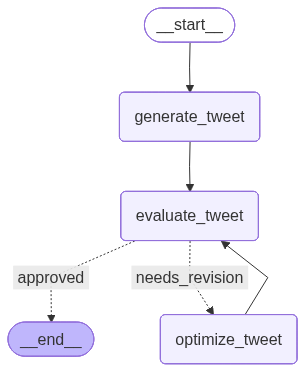

In [51]:
graph = StateGraph(TweetState)

# nodes
graph.add_node("generate_tweet", gen_tweet)
graph.add_node("evaluate_tweet", eval_tweet)
graph.add_node("optimize_tweet", opt_tweet)

# edges
graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluate_tweet")
graph.add_conditional_edges(
    "evaluate_tweet",
    router,
    {
        "approved": END,
        "needs_revision": "optimize_tweet", # generate new tweet
    }
)
graph.add_edge("optimize_tweet", "evaluate_tweet") # send back the optimized tweet for evaluation

generate_tweet_workflow = graph.compile()
generate_tweet_workflow

In [55]:
initial_state = {
    # "topic": "Anime weebs in India",
    "topic": "LinkedIn influencers thinking they are the ones who made AI.",
    "iteration": 1,
    "max_iterations": 5,
}
output_state = generate_tweet_workflow.invoke(initial_state)

In [56]:
output_state

{'topic': 'LinkedIn influencers thinking they are the ones who made AI.',
 'tweet': '"LinkedIn influencers suddenly an AI expert when the algorithm just auto-populated their \'thought leadership\' articles. \'I\'m the OG AI creator\', said nobody who actually created AI #AI #ThoughtLeadership #OG"',
 'evaluation': 'approved',
 'feedback': "This tweet effectively utilizes humor, originality, and virality. The use of sarcasm and irony towards LinkedIn influencers creates a relatable and amusing tone, while the reference to AI experts and the hashtag #OG adds to its originality. However, the tweet could benefit from a slight adjustment to ensure it doesn't come across as overly aggressive or divisive. Nevertheless, the tweet meets the format requirements, making it suitable for approval.",
 'iteration': 1,
 'max_iterations': 5,
 'tweet_history': ['"LinkedIn influencers suddenly an AI expert when the algorithm just auto-populated their \'thought leadership\' articles. \'I\'m the OG AI crea

In [57]:
for idx, tweet in enumerate(output_state['tweet_history']):
    print(f"Tweet {idx+1}")
    print(tweet)

Tweet 1
"LinkedIn influencers suddenly an AI expert when the algorithm just auto-populated their 'thought leadership' articles. 'I'm the OG AI creator', said nobody who actually created AI #AI #ThoughtLeadership #OG"
